<img src="../images/cmip6-cookbook-thumbnail.png" width=250 alt="CMIP6 image"></img>

# Global Mean Surface Temperature

---

## Overview

This notebook uses similar techniques to the [ECS notebook](ecs-cmip6.ipynb). Please refer to that notebook for details.

## Prerequisites

| Concepts | Importance | Notes |
| --- | --- | --- |
| [Understanding of NetCDF](https://foundations.projectpythia.org/core/data-formats/netcdf-cf.html) | Helpful | Familiarity with metadata structure |
| Seaborn | Helpful | |

- **Time to learn**: 10 minutes

---

## Imports

In [1]:
from matplotlib import pyplot as plt
import xarray as xr
import numpy as np
import dask
from dask.diagnostics import progress
from tqdm.autonotebook import tqdm
import intake
import fsspec
import seaborn as sns

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/tmp/ipykernel_463/2234965176.py:6: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


In [3]:
[eid for eid in col.df['experiment_id'].unique() if 'ssp' in eid]

['ssp585',
 'ssp245',
 'ssp370SST-lowCH4',
 'ssp370-lowNTCF',
 'ssp370SST-lowNTCF',
 'ssp370SST-ssp126Lu',
 'ssp370SST',
 'ssp370pdSST',
 'ssp119',
 'ssp370',
 'esm-ssp585-ssp126Lu',
 'ssp126-ssp370Lu',
 'ssp370-ssp126Lu',
 'ssp126',
 'esm-ssp585',
 'ssp245-GHG',
 'ssp245-nat',
 'ssp460',
 'ssp434',
 'ssp534-over',
 'ssp245-stratO3',
 'ssp245-aer',
 'ssp245-cov-modgreen',
 'ssp245-cov-fossil',
 'ssp245-cov-strgreen',
 'ssp245-covid',
 'ssp585-bgc']

There is currently a significant amount of data for these runs:

In [4]:
expts = ['historical', 'ssp245', 'ssp585']

query = dict(
    experiment_id=expts,
    table_id='Amon',
    variable_id=['tas'],
    member_id = 'r1i1p1f1',
)

col_subset = col.search(require_all_on=["source_id"], **query)
col_subset.df.groupby("source_id")[
    ["experiment_id", "variable_id", "table_id"]
].nunique()

/srv/conda/envs/notebook/lib/python3.9/site-packages/intake_esm/_search.py:80: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for _, group in grouped:


,experiment_id,variable_id,table_id
source_id,,,
ACCESS-CM2,3,1,1
AWI-CM-1-1-MR,3,1,1
BCC-CSM2-MR,3,1,1
CAMS-CSM1-0,3,1,1
CAS-ESM2-0,3,1,1
CESM2-WACCM,3,1,1
CIESM,3,1,1
CMCC-CM2-SR5,3,1,1
CMCC-ESM2,3,1,1


In [5]:
def drop_all_bounds(ds):
    drop_vars = [vname for vname in ds.coords
                 if (('_bounds') in vname ) or ('_bnds') in vname]
    return ds.drop(drop_vars)

def open_dset(df):
    assert len(df) == 1
    ds = xr.open_zarr(fsspec.get_mapper(df.zstore.values[0]), consolidated=True)
    return drop_all_bounds(ds)

def open_delayed(df):
    return dask.delayed(open_dset)(df)

from collections import defaultdict
dsets = defaultdict(dict)

for group, df in col_subset.df.groupby(by=['source_id', 'experiment_id']):
    dsets[group[0]][group[1]] = open_delayed(df)

In [6]:
dsets_ = dask.compute(dict(dsets))[0]

/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)
/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/coding/times.py:682: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  dtype = _decode_cf_datetime_dtype(data, units, calendar, self.use_cftime)


/srv/conda/envs/notebook/lib/python3.9/site-packages/xarray/core/indexing.py:524: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using cftime.datetime objects instead, reason: dates out of range
  return np.asarray(array[self.key], dtype=None)


Calculate global means:

In [7]:
def get_lat_name(ds):
    for lat_name in ['lat', 'latitude']:
        if lat_name in ds.coords:
            return lat_name
    raise RuntimeError("Couldn't find a latitude coordinate")

def global_mean(ds):
    lat = ds[get_lat_name(ds)]
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

In [8]:
expt_da = xr.DataArray(expts, dims='experiment_id', name='experiment_id',
                       coords={'experiment_id': expts})

dsets_aligned = {}

for k, v in tqdm(dsets_.items()):
    expt_dsets = v.values()
    if any([d is None for d in expt_dsets]):
        print(f"Missing experiment for {k}")
        continue

    for ds in expt_dsets:
        ds.coords['year'] = ds.time.dt.year

    # workaround for
    # https://github.com/pydata/xarray/issues/2237#issuecomment-620961663
    dsets_ann_mean = [v[expt].pipe(global_mean)
                             .swap_dims({'time': 'year'})
                             .drop('time')
                             .coarsen(year=12).mean()
                      for expt in expts]

    # align everything with the 4xCO2 experiment
    dsets_aligned[k] = xr.concat(dsets_ann_mean, join='outer',
                                 dim=expt_da)

  0%|          | 0/34 [00:00<?, ?it/s]

In [9]:
dsets_aligned_ = dask.compute(dsets_aligned)[0]

In [10]:
source_ids = list(dsets_aligned_.keys())
source_da = xr.DataArray(source_ids, dims='source_id', name='source_id',
                         coords={'source_id': source_ids})

big_ds = xr.concat([ds.reset_coords(drop=True)
                    for ds in dsets_aligned_.values()],
                    dim=source_da)

big_ds

<xarray.Dataset>
Dimensions:        (year: 451, experiment_id: 3, source_id: 34)
Coordinates:
  * year           (year) float64 1.85e+03 1.851e+03 ... 2.299e+03 2.3e+03
  * experiment_id  (experiment_id) <U10 'historical' 'ssp245' 'ssp585'
  * source_id      (source_id) <U16 'ACCESS-CM2' 'AWI-CM-1-1-MR' ... 'TaiESM1'
Data variables:
    tas            (source_id, experiment_id, year) float64 287.0 287.0 ... nan

In [11]:
df_all = big_ds.sel(year=slice(1900, 2100)).to_dataframe().reset_index()
df_all.head()

,year,experiment_id,source_id,tas
0,1900.0,historical,ACCESS-CM2,287.019917
1,1900.0,historical,AWI-CM-1-1-MR,286.958154
2,1900.0,historical,BCC-CSM2-MR,287.996260
3,1900.0,historical,CAMS-CSM1-0,287.084974
4,1900.0,historical,CAS-ESM2-0,287.263682


/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/axisgrid.py:848: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  func(*plot_args, **plot_kwargs)


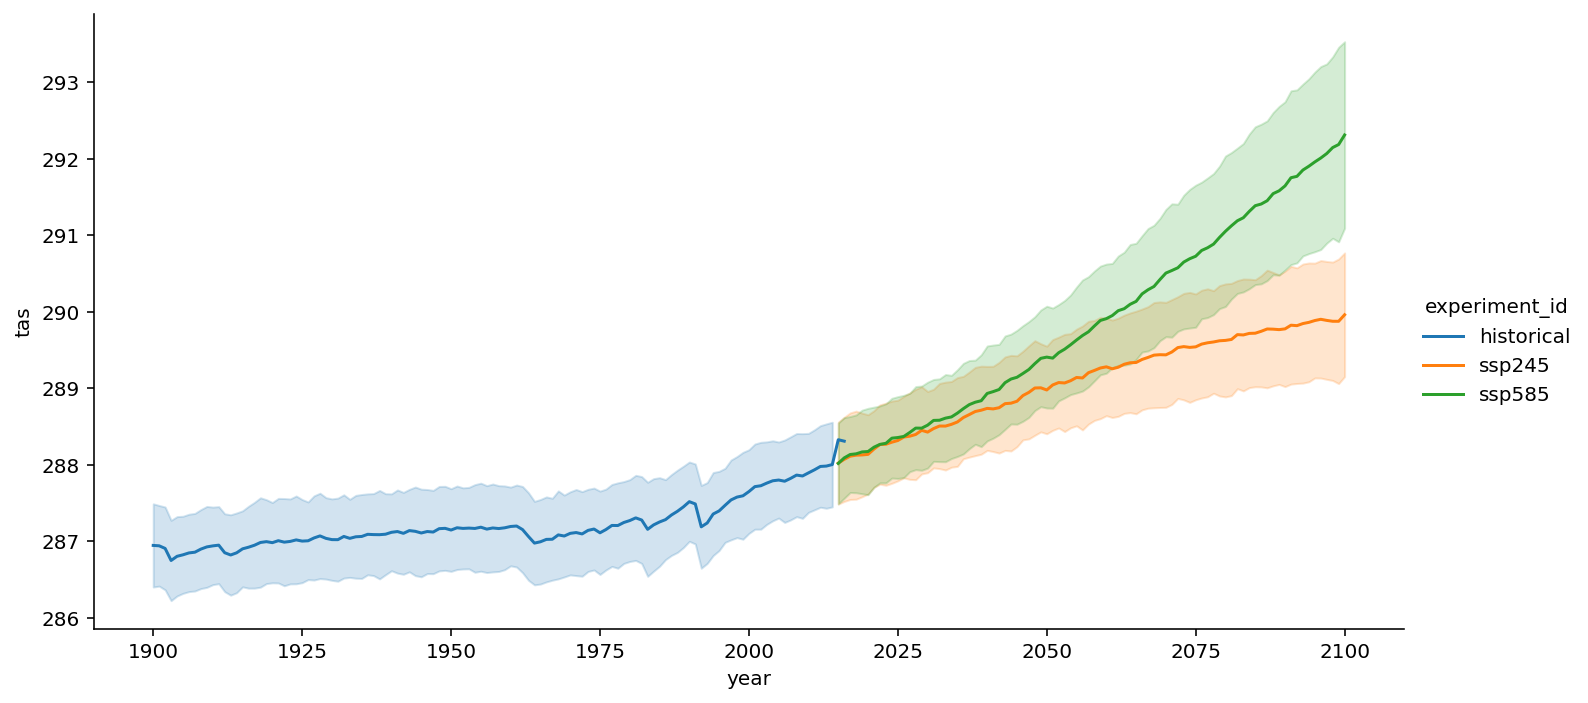

In [12]:
sns.relplot(data=df_all,
            x="year", y="tas", hue='experiment_id',
            kind="line", ci="sd", aspect=2);

---

## Summary
In this notebook, we accessed data for historical, SSP245, and SSP585 runs from a collection of CMIP6 models and plotted the multimodel-mean global average surface air temperature for each run.

### What's next?
We will use CMIP6 data to analyze precipitation intensity under a warming climate.

## Resources and references
- [Original notebook in the Pangeo Gallery](http://gallery.pangeo.io/repos/pangeo-gallery/cmip6/global_mean_surface_temp.html) by Henri Drake and [Ryan Abernathey](https://ocean-transport.github.io/)